In [8]:
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import os
from dataset import MyDataset
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
from utils import *
from skimage.transform import resize
import matplotlib.patches as patches
from matplotlib import gridspec
from utils import *
from models.model_utils import *
from collections import defaultdict

In [10]:
def model_forward(datas, model, args, model_recon=None, args_recon=None,
                  sampling_times=1, checkattention=False, device='cuda:0'):
    map_out = None
    output_recon = {'recon_mean':None, 'evar':None, 'avar':None, 'apara': None}
    
    with torch.no_grad():
        qmap = datas['qmap'].to(device=device).unsqueeze(0)
        pdmap = datas['pdmap'].to(device=device).unsqueeze(0)
        images = datas['images'].to(device=device).unsqueeze(0)
        measurement = datas['measurement'].to(device=device).unsqueeze(0)
        sensmap = datas['sensmap'].to(device=device).unsqueeze(0)
        mask = datas['mask'].to(device=device).unsqueeze(0)
        roi = datas['roi'].to(device=device).unsqueeze(0)
        map_target = torch.cat([pdmap, qmap / args.q_max], dim=1).squeeze(2)
        
        if args.mapping == 'T1':
            images_target = images.real.squeeze(2)
        elif args.mapping == 'T2':
            images_target = torch.abs(images).squeeze(2)
        else:
            print('Unknown mapping type')
            raise(ValueError)

        if args.model_name in ['Dopamine']:
            TE_t = torch.tensor(args.TEs, device=qmap.device)
            images_zf = torch.fft.ifft2(measurement, dim=(-2,-1), norm='ortho') #(B, phase, coils, H, W)
            images_zf_combine = torch.sum(images_zf * sensmap.conj(), dim=2) #(B, phase, H, W)
            images_zf_combine = images_zf_combine.unsqueeze(1)
            sgmodel = SignalModel_T2decay(TE_t, args.q_max).to(device)
            
            sensmap = torch.permute(sensmap, (0,2,1,3,4))
            mask = torch.permute(mask, (0,2,1,3,4))
            measurement = torch.permute(measurement, (0,2,1,3,4))
            map_x0, map_out = model(imgW_init=images_zf_combine, signal_model=sgmodel,
                                smaps=sensmap, masks=mask, kdatas=measurement)
            map_out = torch.cat([map_out[:,:1], map_out[:,2:]], dim=1)
            
        elif args.model_name in ['MANTIS']:
            images_zf = torch.fft.ifft2(measurement, dim=(-2,-1), norm='ortho')
            images_zf = images_zf.view([images_zf.shape[0], -1, images_zf.shape[-2], images_zf.shape[-1]])
            images_zf = c2r(images_zf, axis=1)
            map_out = model.forward(images_zf)
            
            images_zf = torch.fft.ifft2(measurement, dim=(-2,-1), norm='ortho')
            images_zf = images_zf.view([images_zf.shape[0], -1, images_zf.shape[-2], images_zf.shape[-1]])
            images_zf = c2r(images_zf, axis=1)
            
            map_out = model.forward(images_zf)
            #print(torch.mean(images_zf), torch.mean(map_target))
            #print(torch.max(images_zf), torch.min(images_zf))
            #print(torch.max(map_target), torch.min(map_target))
            
        elif args.model_name in ['unroll', 'convnet', 'unet', 'crnn']:
            if args.state == 'recon':
                output_recon = unroll_recon_forward(model, images, measurement,
                                                    sensmap, mask, sampling_times,
                                                    args, grad=False)
            if args.state == 'fitting':
                output_recon = unroll_recon_forward(model_recon, images, measurement,
                                                    sensmap, mask, sampling_times,
                                                    args_recon)
                if args.model_name in ['convnet']:
                    map_out = model(output_recon, guidetype=args.guidetype, var_norm=args.var_norm)
                else:
                    map_out = model(output_recon['recon_mean'])
                    
                if not checkattention:
                    attention = None
                    
        elif args.model_name in ['fcn']:
            output_recon = unroll_recon_forward(model_recon, images, measurement,
                                                sensmap, mask, sampling_times, args_recon,
                                                grad=False, delta=1)
            output_image = output_recon['recon_mean']
            h, w = output_image.shape[-2], output_image.shape[-1]
            output_image = output_image.view(output_image.shape[0], output_image.shape[1], -1)
            if args.pipe_type == 'model_uq':
                if output_recon['avar'] is not None:
                    uq = output_recon['avar']
                else:
                    uq = output_recon['evar']
                uq = uq.view(uq.shape[0], uq.shape[1], -1)
            images_target_ = images_target.view(images_target.shape[0], images_target.shape[1], -1)
            out_map_list = []
            for i in range(output_image.shape[-1]):
                sig = output_image[:,:,i]
                if args.pipe_type == 'model_uq':
                    uq_s = uq[:,:,i]
                    sig = torch.cat([sig, uq_s], dim=1)
                sig = sig / sig[:, 0]
                pred_map = model(sig)
                out_map_list.append(pred_map)
                
            map_out = torch.stack(out_map_list, dim=-1)
            map_out = map_out.view(map_out.shape[0], map_out.shape[1], h, w)
            map_out = torch.cat([output_recon['recon_mean'][:,:1], map_out], dim=1)
            
        else:
            raise(ValueError)
        
        #if hasattr(args, 'loss_mask') and map_out is not None:
        map_out = map_out * roi
        map_target = map_target * roi
        
        output_map = {'map_out':map_out, 'map_target':map_target}
        output_recon.update({'image_target':images_target})
        output_recon.update({'mask':mask})
        if checkattention:
            output_recon.update({'attention':attention})
    return output_recon, output_map


In [11]:
def torch2np(tensor):
    if tensor is not None:
        return tensor[0].cpu().detach().numpy()
    else:
        return None

def test_single(config_path, idx, sampling_times=None, checkattention=False, device='cuda:0', recon_model_path=None):
    args, args_model = get_args(config_path)
    if recon_model_path is not None:
        args.recon_model_path = recon_model_path
    if sampling_times is None:
        if hasattr(args, 'sampling_times'):
            sampling_times = args.sampling_times
        else:
            sampling_times = 1
            if hasattr(args, 'state') and args.state == "fitting":
                args.sampling_times = 1
    
    val_dataset = MyDataset(directory=os.path.join(args.root_dir, 'test'), q_th=args.q_th, q_max=args.q_max,
                            center_fractions=args.center_fractions, accelerations=args.sampling_factor,
                            mapping=args.mapping)
    random_seed = args.seed
    set_random_seed(random_seed, True)
    # load best model
    model = get_model(args).to(device)

    if hasattr(args, 'state') and args.state == "fitting":
        args_recon, args_model_recon = get_args(args.recon_model_path)
        save_sub_dir, save_label = get_savepath(args, args_model)
        save_sub_dir_recon, save_label_recon = get_savepath(args_recon, args_model_recon)
        save_path_recon = os.path.join(args.save_dir, save_sub_dir_recon, save_label_recon)
        if args.model_name not in ['fcn']:
            save_path = os.path.join(args.save_dir, save_sub_dir + '_recon_' + save_sub_dir_recon,
                                    save_label + '_recon_' + save_label_recon)
        else:
            save_path = os.path.join(args.save_dir, save_sub_dir, save_label)
        
        model_recon = get_model(args_recon).to(device)
        checkpoint = torch.load(save_path_recon + '_best_.pth')
        model_recon.load_state_dict(checkpoint['model_state'])
        
        model.eval()
        model_recon.eval()
        if sampling_times > 1:
            activate_drop(model_recon)
        bset_score_criterion = "nmse_t2"
    else:
        model_recon = None
        args_recon = None
        bset_score_criterion = "nmse"
        save_sub_dir, save_label = get_savepath(args, args_model)
        save_path = os.path.join(args.save_dir, save_sub_dir, save_label)
        model.eval()
        if sampling_times > 1:
            activate_drop(model)
    
    model.load_state_dict(torch.load(save_path + '_best_.pth')["model_state"])

    data_batch = val_dataset[idx]
    output_recon, output_map = model_forward(data_batch, model, args, model_recon, args_recon,
                                             sampling_times=sampling_times, checkattention=checkattention,
                                             device=device)
    # for map
    if output_map['map_out'] is not None:
        map_out = output_map['map_out']
        pdmap_output = map_out[0, 0].cpu().numpy()
        qmap_output = map_out[0, 1].cpu().numpy() * args.q_max
    else:
        pdmap_output = None
        qmap_output = None
    
    map_target = output_map['map_target']
    pdmap_target = map_target[0, 0].cpu().numpy()
    qmap_target = map_target[0, 1].cpu().numpy() * args.q_max
    
    # for recon
    output_recon_np = defaultdict()
    for key in output_recon.keys():
        if key == 'attention' and output_recon[key] is not None:
            output_recon_np[key] = [torch2np(attention) for attention in output_recon[key]]
        else:
            output_recon_np[key] = torch2np(output_recon[key])
    

    return qmap_target, pdmap_target, qmap_output, pdmap_output, output_recon_np

def get_metric(target, output):
    mse = np.mean((target - output) ** 2)
    norms = np.mean(target ** 2)
    nrmse = np.sqrt(mse / norms)
    ssim = structural_similarity(output, target, win_size=11, data_range=target.max())
    
    return {'nrmse':nrmse, 'ssim':ssim}


In [12]:
def show_with_inv(imglist, textlist=[], inv=0.01, cmap='gray',
                  imax=1, imin=0, addrect=False, zoomloc=None,
                  point_marker=None, markercolor='r', markersize=0.5):
    w = len(imglist)
    plt.figure(dpi=300)
    for i in range(w):
        plt.subplot(1, w, i+1, frame_on=False)
        plt.imshow(imglist[i], cmap=cmap, vmax=imax, vmin=imin)
        if point_marker is not None:
            plt.scatter(point_marker[0], point_marker[1], color=markercolor, s=markersize)
        plt.axis('off')
        if i==0 and addrect:
            rect = patches.Rectangle((zoomloc[2], zoomloc[0]), zoomloc[3]-zoomloc[2], zoomloc[1]-zoomloc[0],
                                    linewidth=0.8, edgecolor='r', fill=False)
            plt.gca().add_patch(rect)
        if len(textlist)>0:
            plt.text(130, 4, textlist[i], fontproperties='Times New Roman',
                        fontweight=1000, fontsize=7, color=[245./255.,130./255.,0./255.],
                        horizontalalignment='right', verticalalignment='top')

    plt.gca().xaxis.set_major_locator(plt.NullLocator())
    plt.gca().yaxis.set_major_locator(plt.NullLocator())
    plt.subplots_adjust(top=1, bottom=0, right=1, left=0, hspace=0, wspace=inv)
    plt.margins(0,0)
    plt.axis('off')

In [13]:
yaml_bw_path = []
yaml_bw_path.append('./config/MANTIS.yaml')
yaml_bw_path.append('./config/Dopamine.yaml')
yaml_bw_path.append('./config/Deept1_fit.yaml')
yaml_bw_path.append('./config/PUQ_wo_fit.yaml')
yaml_bw_path.append('./config/PUQ_fit.yaml')

yaml_recon_path = [None, None, None,
                   './config/PUQ_recon.yaml',
                   './config/PUQ_recon.yaml']

sampling_times_list = [1, 1, 1, 100, 100]
outputlist_q = []
metriclist_q = []
idx = 46
output_recon_np_list = []
for i, yaml in enumerate(yaml_bw_path):
    qmap_target, pdmap_target, qmap_output, pdmap_output, output_recon_np = test_single(yaml, idx, device="cuda:1",
                                                                                          recon_model_path=yaml_recon_path[i],
                                                                                          sampling_times=sampling_times_list[i])
    metric_q = get_metric(qmap_target, qmap_output)
    outputlist_q.append(qmap_output)
    metriclist_q.append(metric_q)

/home/shz/anaconda3/envs/fcp/lib/python3.8/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [17]:
# prepare for show
imglist = [qmap_target]
imglist.extend(outputlist_q)
imax, imin = 500, 0
img_norm = 1000
zoomloc = [50,110,145,255]

cmap='viridis'
addrect=False
inv=0.01
textlist = []
textlist.append('NRMSE / SSIM')
for i in range(len(outputlist_q)):
    nrmse, ssim = metriclist_q[i]['nrmse'], metriclist_q[i]['ssim']
    textlist.append(f'{nrmse:.5f} / {ssim:.4f}')

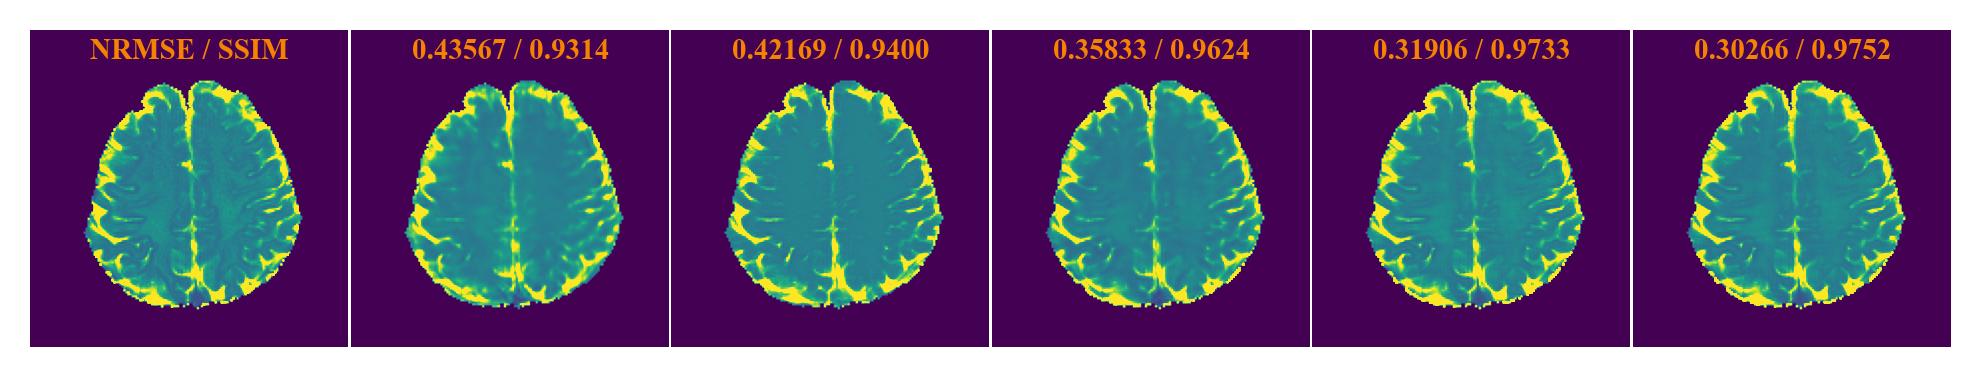

In [15]:
show_with_inv(imglist, textlist=textlist, inv=inv, cmap=cmap, imax=0.25, imin=0,)

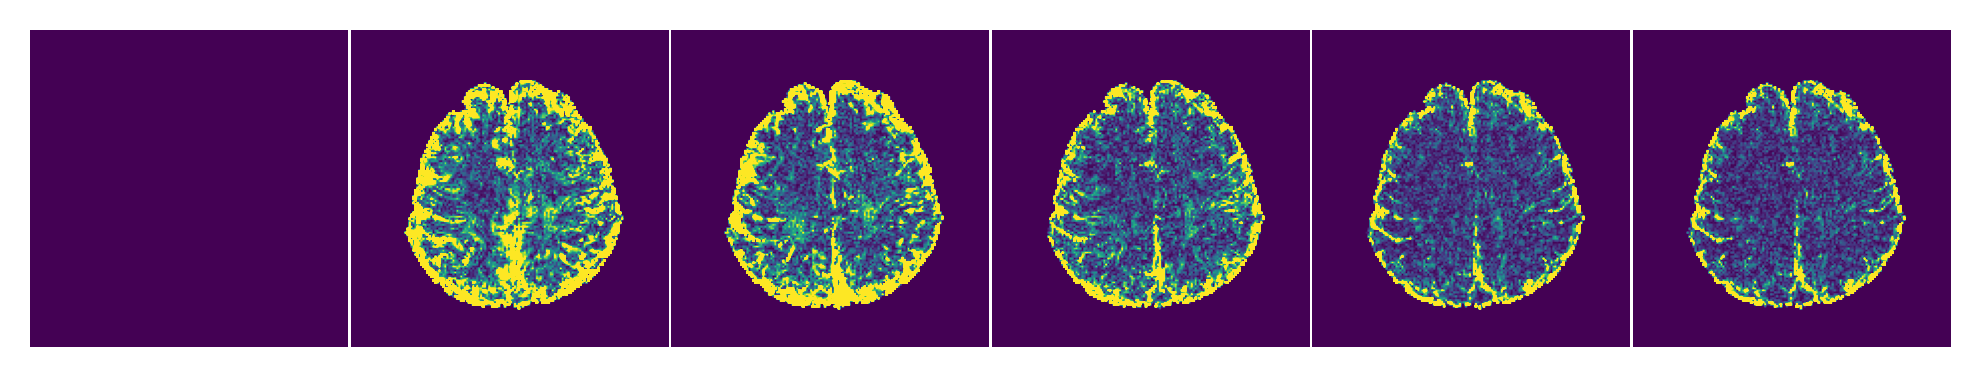

In [16]:
errorlist = [abs(imglist[i] - qmap_target) for i in range(len(imglist))]
show_with_inv(errorlist, textlist=[], inv=inv, cmap=cmap, imax=0.25/10, imin=0)